# **Task 6: Template Fitting of Extragalactic Objects' Spectra:**
This example will walk you through the basic template fitting of a 1-dimension spectrum of Seyfert-1 galaxy. The spectrum, although (in some cases) dominated by the AGN, contain significant fraction of host galaxy flux and features.

Install the following require packages:

*   astropy
*   extinction
*   astroML
*   specutils



In [1]:
#!pip install astropy
#!pip install astroML
#!pip install spectres
#!pip install specutils
# Installing needed Python packages

First, let's call in the usual suspects (i.e. import normally used packages)


*   NumPy
*   SciPy
*   Matplotlib.Pyplot
*   AstroPy
*   Specutils
*   etc...

And also the packages you just installed (for online participants).



In [2]:
! pip install specutils

/bin/bash: /home/pkhamchuai/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
import numpy as np
from urllib.error import HTTPError
from astroML.datasets import fetch_sdss_spectrum

from astropy.convolution import convolve, Gaussian1DKernel
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from astropy.modeling.models import Linear1D, Polynomial1D

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy import signal

import specutils
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum
from specutils.analysis import correlation
import pandas as pd
import os

#**Block 6.1:**

Now, let's read in a spectrum of Seyfert-1 galaxy and also a template of AGN from the folders.

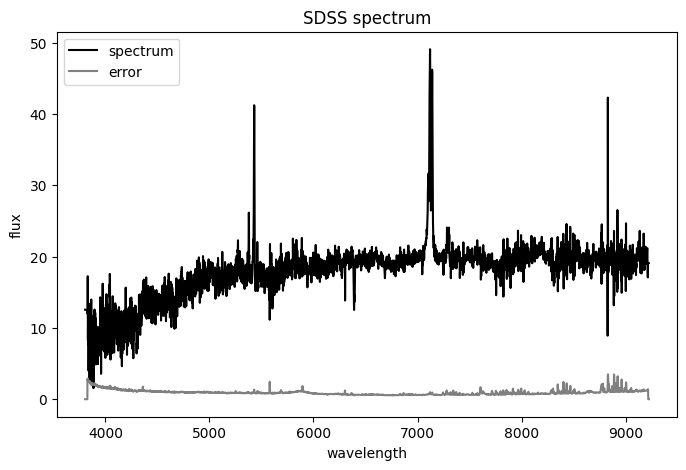

In [4]:
data_file_path = 'data/table_dr17_all_low_luminosity_AGN.csv'
data = pd.read_csv(data_file_path)
specObjID, ra, dec, plate, fiberID, redshift_table, mjd = data['specObjID'], data['ra'], data['dec'], data['plate'], data['fiberID'], data['redshift'], data['mjd']
# plt.hist(redshift_table,bins=10)

def get_sdss_spec(plate,mjd,fiber): # in Place of 'Macro subtract_plot 13'
    try:
        spec = fetch_sdss_spectrum(plate, mjd, fiber)
    except HTTPError:
        print("%i, %i, %i not found" % (plate, mjd, fiber))
        spec = None
    return spec

index = 25

#plot the spectrum you just obtain from the query
spec = get_sdss_spec(plate[index], mjd[index], fiberID[index])
plt.figure(figsize=(8,5))
plt.plot(spec.wavelength(), spec.spectrum, '-k', label='spectrum')
plt.plot(spec.wavelength(), spec.error, '-', color='gray', label='error')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.title('SDSS spectrum')
plt.legend(loc=2)
plt.show()



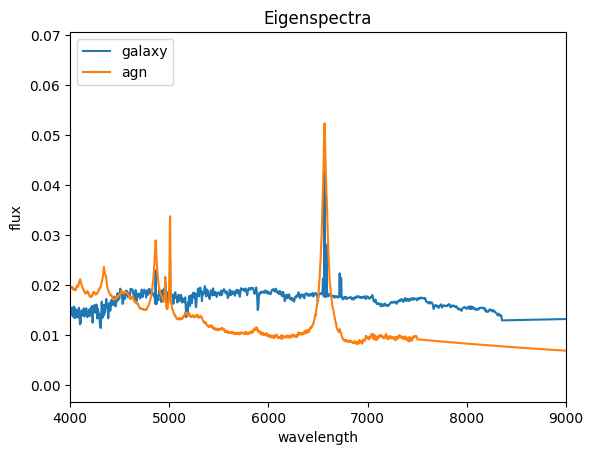

In [5]:
# Reading in Templates

template_agn_path = 'data/eigenspectra/agn/eigSpec_qso_'
template_gal_path = 'data/eigenspectra/galaxy/galaxyKL_eigSpec_'


gal_ord = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
agn_ord = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

# Try the first order eigenspectrum of each catagory first
# Plot them to see what they look like
wl_gal, flux_gal = np.loadtxt(template_gal_path + gal_ord[0] + '.dat', unpack=True, usecols = (0,1))
wl_agn, flux_agn = np.loadtxt(template_agn_path + agn_ord[0] + '.dat', unpack=True, usecols = (0,1))

plt.plot(wl_gal, flux_gal, label='galaxy')
plt.plot(wl_agn, flux_agn, label='agn')
plt.xlim([4000, 9000])
#plt.ylim([np.min(), 1.1*np.max()])
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.title('Eigenspectra')
plt.legend(loc=2)


#**Block 6.2:**
Since that you see what the templates look like.
Decide what would be the most appropriate to extract redshift of our "real" galaxy.


*   Perform cross-correlation
*   Before that, we need to "clean" the spectra (both observed and template) from continuum.
*   Why is that the case?
*   Does this change your prior decision/conclusion?



In [6]:
#Put the template and the observed spectrum into "Spectrum1D" packaging
#First crop the template to between 4000 to 8000 angstrom

tem_crop = np.where((wl_gal > 4000) & (wl_gal < 8000))
flux_unit = u.Unit('1e-17 erg cm-2 s-1 AA-1')
template = Spectrum1D(spectral_axis=wl_gal[tem_crop]*u.AA, flux=flux_gal[tem_crop]*flux_unit)


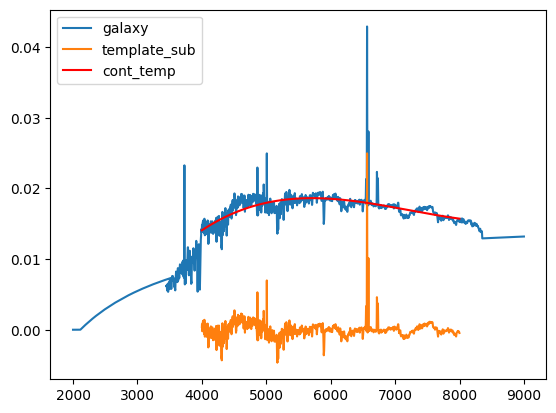

In [11]:
#Fit continuum using "fit_generic_continuum"
from astropy.modeling.polynomial import Chebyshev1D

fit_temp = fit_generic_continuum(template, median_window=3, model=Chebyshev1D(3))
cont_temp = fit_temp(template.spectral_axis)
template_sub = template - cont_temp

plt.plot(wl_gal, flux_gal, label='galaxy')
plt.plot(template_sub.spectral_axis, template_sub.flux, label='template_sub')
plt.plot(template_sub.spectral_axis, cont_temp, label='cont_temp', color='red')
plt.legend(loc=2)

Text(0.5, 1.0, 'Continuum subtracted observed spectrum')

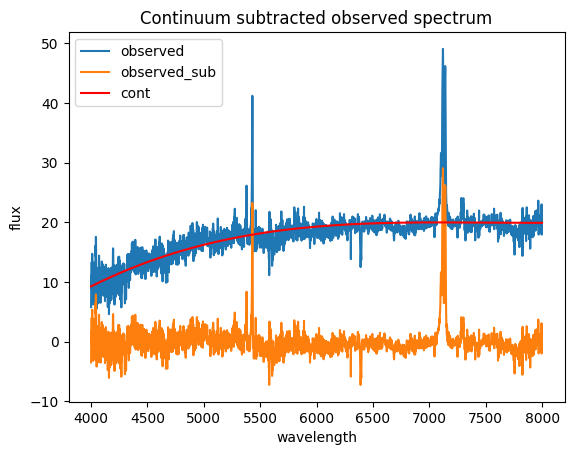

In [14]:
#Now fit and subtract of the continuum of the "observed" spectrum
obs_crop = np.where((spec.wavelength() > 4000) & (spec.wavelength() < 8000))
observed = Spectrum1D(spectral_axis=(spec.wavelength()[obs_crop]*u.AA), flux=spec.spectrum[obs_crop]*flux_unit, uncertainty=StdDevUncertainty(spec.error[obs_crop]*flux_unit))

# get observed spectrum
wl_1 = observed.spectral_axis
flux_1 = observed.flux
error_1 = observed.uncertainty.array

# follow the above solution you worked out from "template part"
# plot your continuum subtracted observed spectrum in similar fashion.
fit = fit_generic_continuum(observed, median_window=3, model=Chebyshev1D(3))
cont = fit(observed.spectral_axis)
observed_sub = observed - cont

plt.plot(wl_1, flux_1, label='observed')
plt.plot(observed_sub.spectral_axis, observed_sub.flux, label='observed_sub')
plt.plot(observed_sub.spectral_axis, cont, label='cont', color='red')
plt.legend(loc=2)
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.title('Continuum subtracted observed spectrum')


In [15]:
print(observed_sub)
print(template_sub)
#Just checking (make a sanity check here).

Spectrum1D (length=3010)
flux:             [ -3.4693 1e-17 erg / (Angstrom cm2 s), ..., -1.348 1e-17 erg / (Angstrom cm2 s) ],  mean=0.0080572 1e-17 erg / (Angstrom cm2 s)
spectral axis:    [ 4000.4 Angstrom, ..., 7998.3 Angstrom ],  mean=5770.4 Angstrom
uncertainty:      [ StdDevUncertainty(1.6307768), ..., StdDevUncertainty(1.0215511) ]
Spectrum1D (length=3010)
flux:             [ 0.0004047 1e-17 erg / (Angstrom cm2 s), ..., -0.00046242 1e-17 erg / (Angstrom cm2 s) ],  mean=1.5302e-06 1e-17 erg / (Angstrom cm2 s)
spectral axis:    [ 4000.5 Angstrom, ..., 7998.7 Angstrom ],  mean=5770.7 Angstrom


#**Block 6.3: Good, good, goooood!**
Now, we are really ready for the cross-correlation part of the exercise.

*   Perform cross-corelation using "correlation.template_correlate(observed, template, lag_units=u...)" from "specutils.analysis"
*   Compare the redshift you get from this method to the listed redshift from SDSS.


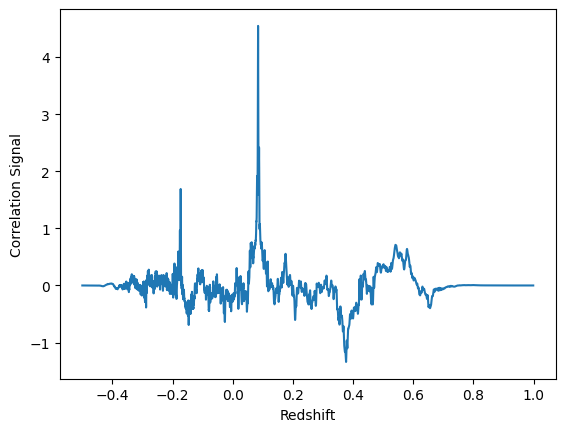

In [19]:
# Call the correlation function
# lag_units must be either velocity or dimensionless
corr, lag = correlation.template_correlate(observed_sub, template_sub, lag_units=u.dimensionless_unscaled)

# Plot the correlation
plt.plot(lag, corr)
plt.xlabel("Redshift")
plt.ylabel("Correlation Signal")
#plt.xlim([,])
#plt.ylim([,])
plt.show()

#Try ploting it first, then review where the peak(s) locates and zoom in!
z_peak = lag[np.where(corr == np.max(corr))]
z_listed_1 = np.where((lag > z_peak - 0.1) & (lag < z_peak + 0.1))
# print(z_listed_1, z_peak)

#**Block 6.4:**
**The Challenging Part**

If you feel incomplete after the series of fitting and fitting, let's do more "challenging" fitting.
As mentioned, the spectra here is one of the Seyfert-1 galaxies. So, the flux is blended between galaxies and those of active galactic nuclei.



*   Try a simple version of PCA decomposition of the spectrum.
*   Using the first 3 eigen spectra from each of AGN and galaxy types.
*   What is the contribution from each sources (host galaxy and AGN)




In [ ]:
#Read in all necessary eigen spectra. No worries. For each type, they "might not" have the same wavelength array.
lambda_gal0, f_gal0 = np.loadtxt(template_gal_path + gal_ord[0] + '.dat', unpack=True, usecols = (0,1))
lambda_gal1, f_gal1 = np.loadtxt(template_gal_path + gal_ord[1] + '.dat', unpack=True, usecols = (0,1))
lambda_gal2, f_gal2 = np.loadtxt(template_gal_path + gal_ord[2] + '.dat', unpack=True, usecols = (0,1))

lambda_agn0, f_agn0 = np.loadtxt(template_agn_path + agn_ord[0] + '.dat', unpack=True, usecols = (0,1))
lambda_agn1, f_agn1 = np.loadtxt(template_agn_path + agn_ord[1] + '.dat', unpack=True, usecols = (0,1))
lambda_agn2, f_agn2 = np.loadtxt(template_agn_path + agn_ord[2] + '.dat', unpack=True, usecols = (0,1))

# "your eigen values to be fitted here"
def eigen_model(x, a, b, c, d, e, f, g, h, i, j):
  flux_dens_total = a*f_gal0 + b*f_gal1 + c*f_gal2 + d*f_agn0 + e*f_agn1 + f*f_agn2 + g*f_gal0 + h*f_gal1 + i*f_gal2 + j*f_agn0 
  return flux_dens_total 


2869 1879 2672 2672


De-redshift the observed spectrum into rest wavelegth and fit it with the function you just built!


In [ ]:
wvl_1_rest = wvl_1/(???)

eigen_vals, eigen_covs = curve_fit(...)

# show your work/result in the plot...

gal_part = eigen_model(???)
agn_part = eigen_model(???)
plt.plot(...)


#Estimate the "host fraction" at wavelenth < 4000.0 angstrom and again at > 7000.0 angstrom
...
...
...
print(host_frac_blue, host_frac_red)

**Is this finding in line with the stuff you (may) have learn about AGN?**